In [88]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
from transformers import GPT2Tokenizer, GPT2Model


def image_features(image_path,device):
    #34 or 152
    weights = models.ResNet34_Weights.DEFAULT
    resnet = models.resnet34(weights=weights)
    resnet = resnet.to(device)
    resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

    # Set model to evaluation mode
    resnet.eval()
    # Define image preprocessing pipeline
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_path =  image_path
    image = Image.open(full_path)
    # Preprocess the image
    image_tensor = preprocess(image)
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    # Move tensor to the selected device
    image_tensor = image_tensor.to(device)
    # Extract features
    with torch.no_grad():
        features = resnet(image_tensor)
    # Flatten the features
    features = features.squeeze().cpu()

    return features

def get_image_features(df, device):
    embeddings = []
    for image_path in df['relative_path']:
        print(image_path)
        embedding = image_features(image_path,device)
        embeddings.append(embedding)
    return embeddings


def preprocess_data(df,dataset_outpath, device):
    '''Preprocess the data and save it as a pickle file'''

    df['image_features'] = get_image_features(df, device)



    df.to_pickle(dataset_outpath)

    return df

def get_embedding(text, model, tokenizer, device):
    # Tokenize the text
    input_ids = tokenizer.encode(text, add_special_tokens=False, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        embedding = outputs.last_hidden_state.squeeze().mean(dim=0).cpu()
    return embedding

def get_text_features(df, device):
    # Load GPT-2 tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_basic_tokenize=False, do_lower_case=False)
    model = GPT2Model.from_pretrained('gpt2').to(device)
    df.loc[:, 'tags'] = df['tags'].fillna(' ')
    # Concatenate text from different columns
    df.loc[:,'concatenated_text'] =  df['title'].astype(str) + ' ' + df['tags'].astype(str) + ' ' + df['timeframe_estimation'].astype(str) 

    # Get embeddings for the concatenated text
    embeddings = []
    for text in df['concatenated_text']:
        embedding = get_embedding(text, model, tokenizer, device)
        embeddings.append(embedding)

    return embeddings

In [90]:
s = pd.read_csv('influence_pairs_test.csv')
s['text_features'] = get_text_features(s,"cpu")

In [92]:
df = pd.read_pickle('test_embeddings.pkl')
df['text_features'] = s['text_features']
df['image_text_features'] = df.apply(lambda x: torch.cat([x['image_features'], x['text_features']]), axis=1)

In [99]:
pd.to_pickle(df,'test_embeddings.pkl')

In [80]:
from matplotlib import pyplot as plt
from PIL import Image
general_image_path = '/home/tliberatore2/Reproduction-of-ArtSAGENet/wikiart/'
def plot_examples(query, positive_indexes, df):
    # Plot single image
    plt.figure(figsize=(10, 5))
    if df.iloc[query]['mode'] == 'test_pair':
        image_path = df.iloc[query].relative_path
    else:
        image_path = general_image_path + df.iloc[query].relative_path
    plt.imshow(Image.open( image_path))
    plt.axis('off')
    plt.title(str(df.loc[query].artist_name + ', influencers: ' + str(df.loc[query].influenced_by)))
    plt.show()

    # Plot grid of images
    fig, axes = plt.subplots(3,3, figsize=(20, 20))  # 5 rows, 2 columns
    for i, ax in enumerate(axes.flatten()):
        if i < len(positive_indexes):
            if df.iloc[positive_indexes[i]]['mode'] == "test_pair":
                image_path = df.iloc[positive_indexes[i]].relative_path
            else:
                image_path = general_image_path + df.iloc[positive_indexes[i]].relative_path
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(str(i+1)+" "+ df.iloc[positive_indexes[i]].artist_name)
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [72]:
import pandas as pd
# df = pd.read_csv('influence_pairs_test.csv')
# preprocess_data(df, 'test_embeddings.pkl',"cpu")
df = pd.read_pickle('test_embeddings.pkl')

USE TRAINED MODEL TO MAKE PREDICTION

In [94]:
from Triplet_Network import TripletResNet_features
feature = 'image_text_features'
model_path = 'trained_models/wikiart/ResNet34/TripletResNet_image_text_features_posfaiss_negrandom_100_margin1/model.pth'
model = TripletResNet_features(df.loc[0,feature].shape[0])
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
df['mode'] = 'test_pair'

In [95]:
df_wikiart_rest = pd.read_pickle('DATA/Dataset/wikiart/wikiart_full_combined_no_artist_filtered.pkl')
appended_df = pd.concat([df, df_wikiart_rest], ignore_index=True)
appended_df[f'trained_{feature}'] = appended_df[feature].apply(lambda x: model.forward_once(x).detach().to('cpu'))

In [96]:
import faiss
def vector_similarity_search(feature, df, query, index_list):
    '''Search for similar vectors in the dataset using faiss library'''
    k = 11
    query_vector = torch.stack(df[feature].tolist())[query].reshape(1, -1)#query.reshape(1, -1)#torch.stack(query.tolist()).reshape(1, -1)
    xb = torch.stack(df[feature].tolist())[index_list]
    d = xb.shape[1]
    index = faiss.IndexFlatL2(d) 
    index.add(xb)
    D, I = index.search(query_vector, k)
    I = list(I[0][1:]) 
    #I = [index_list[i] for i in I]
    return I




In [147]:

index_list = appended_df.index.tolist()
query = 16
#0 and 16
I = vector_similarity_search(feature, appended_df,query,index_list)
#I = vector_similarity_search(f'trained_{feature}', appended_df,query,index_list)
print(I)


[38921, 17, 15417, 32531, 29026, 32530, 2124, 32532, 38919, 27279]


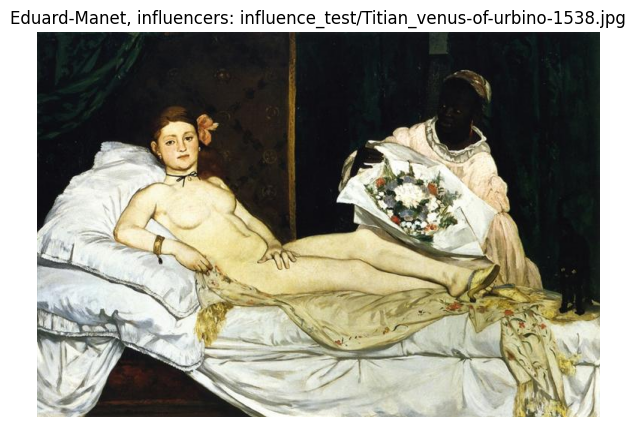

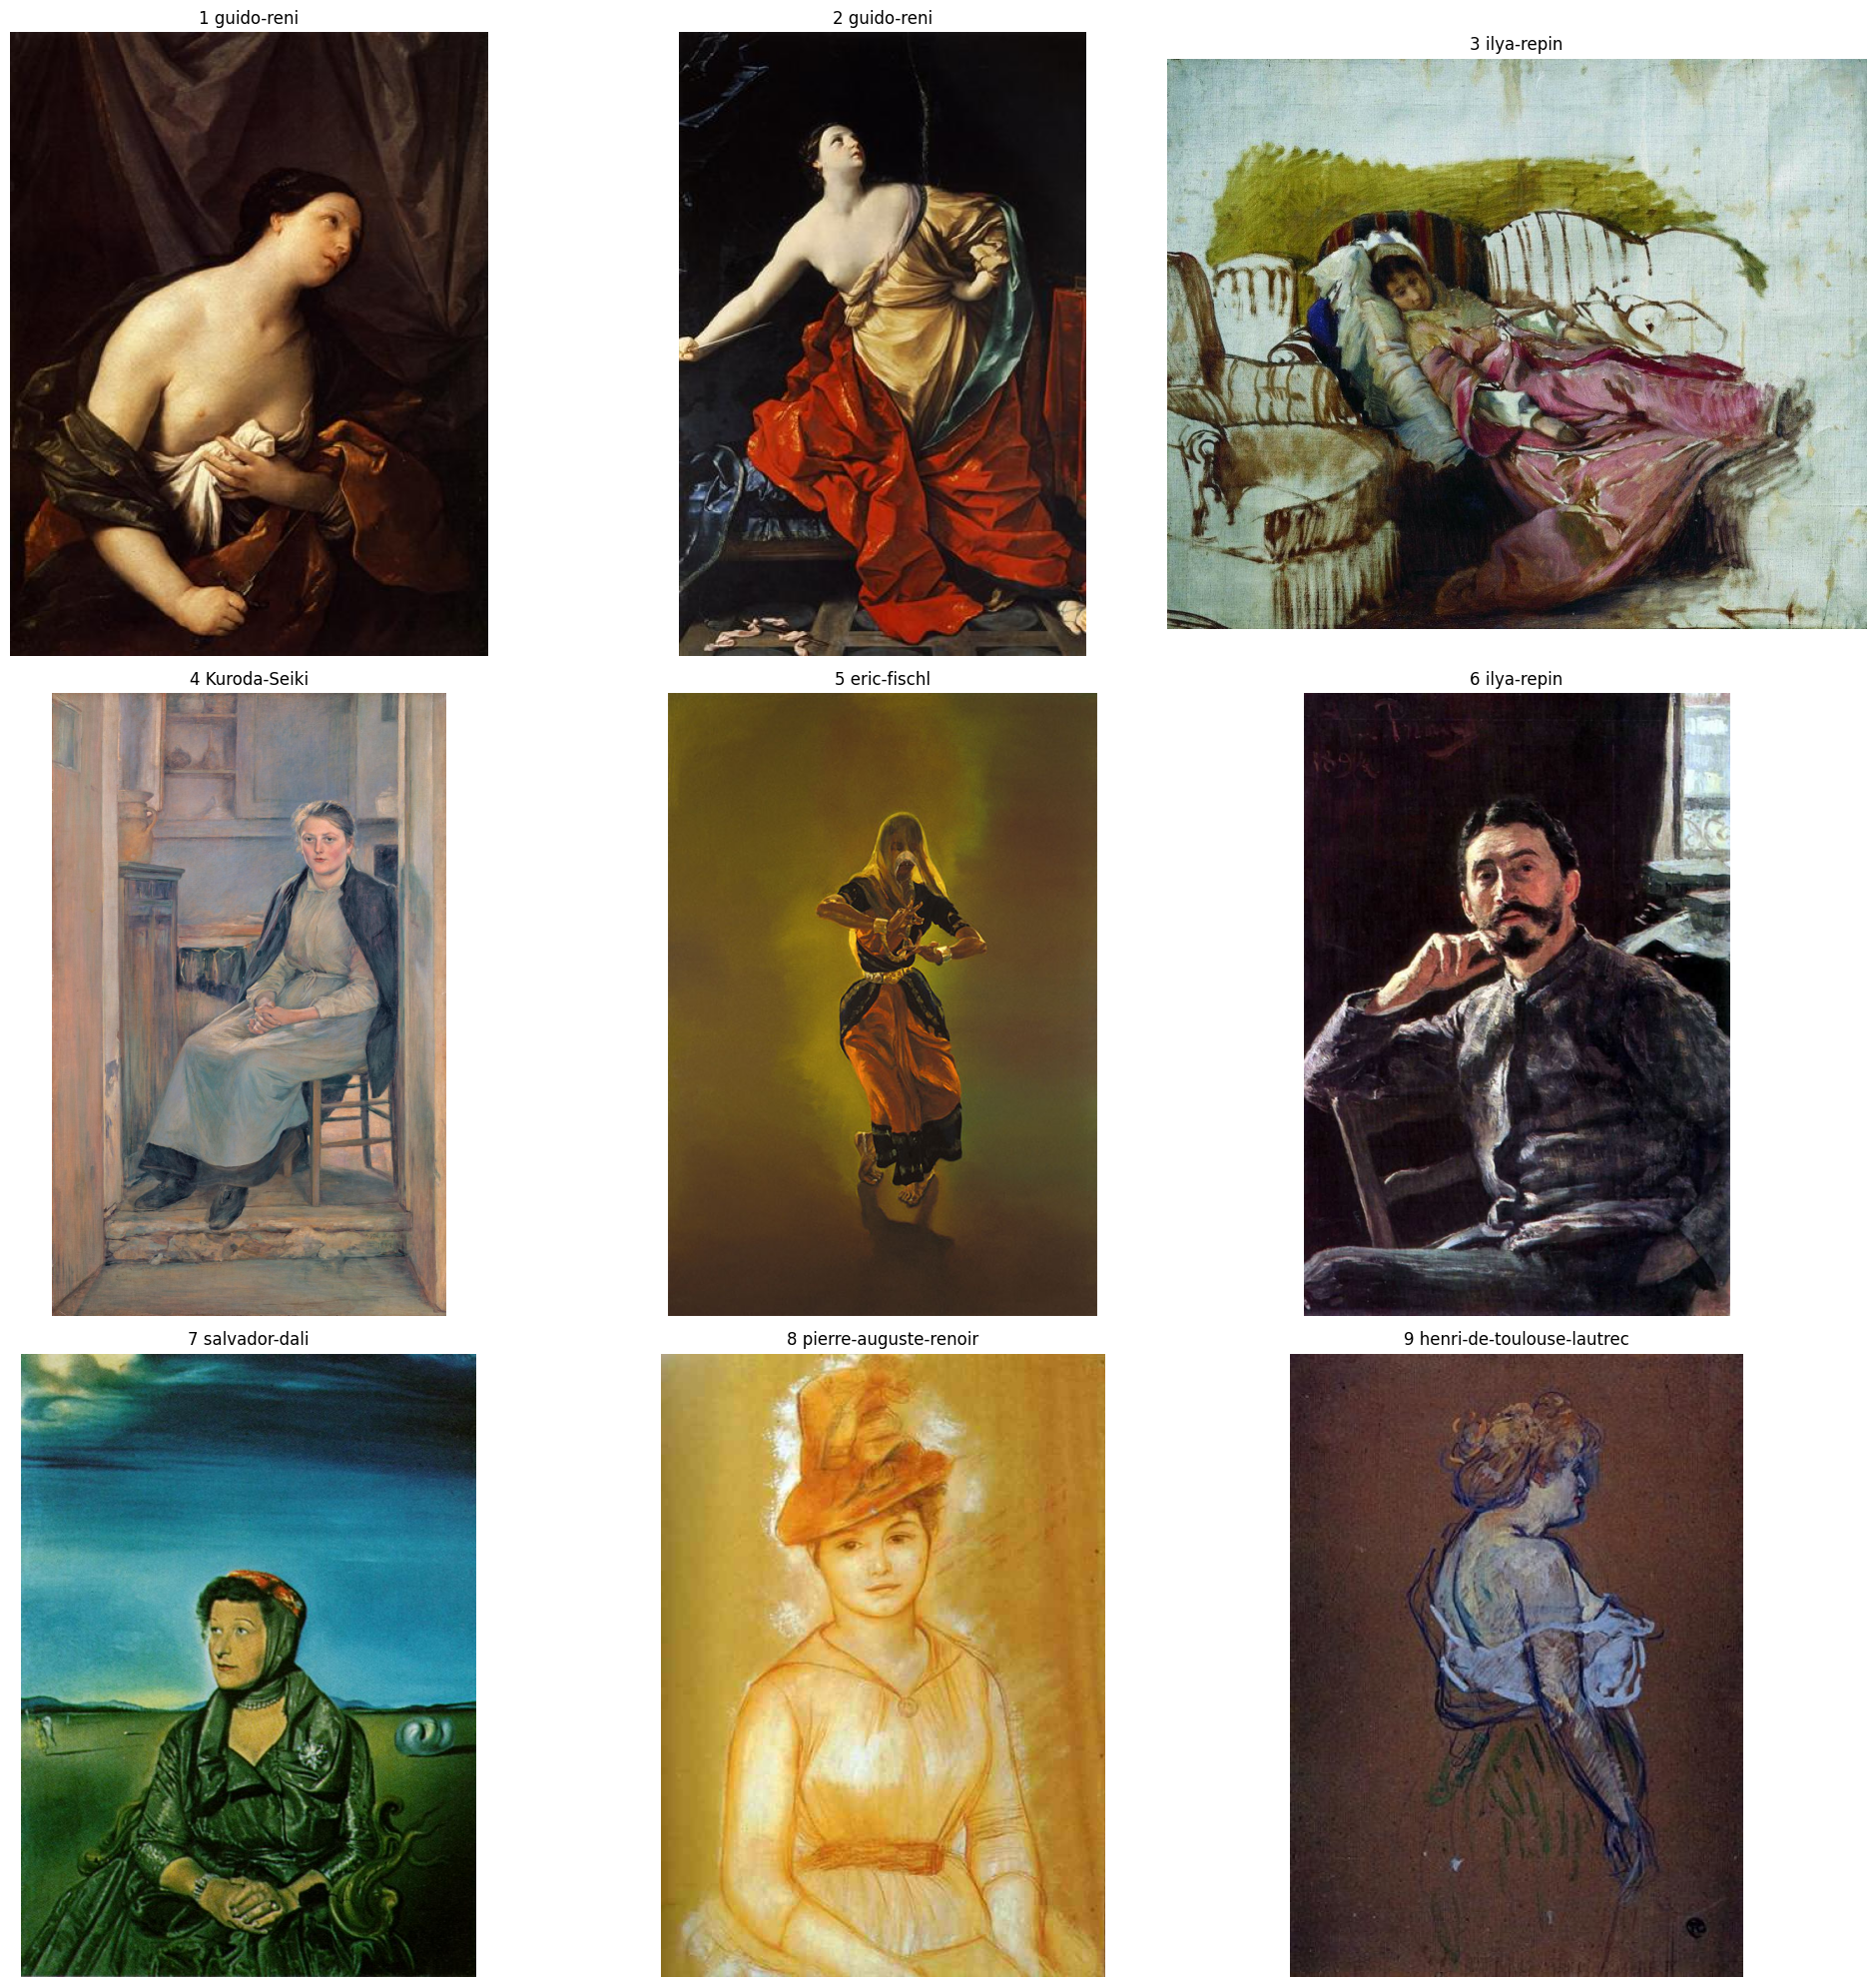

In [137]:
plot_examples(query, I, appended_df)

In [ ]:
plot_examples(query, I, appended_df)